<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/playground_series_s3e25/undraw_Developer_activity_re_39tg.png" width=400px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Playground Series S3E25 - Mohs Hardness</p>

In [325]:
# %load ../utils/config.py
import glob
import os
import shutil
import subprocess
import sys
import warnings
from array import array
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial, singledispatch
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import scipy.stats as stats
import seaborn as sns
import shap
from colorama import Fore, Style
from IPython.display import HTML, Image, display_html
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.base import BaseEstimator, OneToOneFeatureMixin, TransformerMixin

# Environment
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
MAGENTA = Style.BRIGHT + Fore.MAGENTA
RESET = Style.RESET_ALL

# Data Frame and Plotly colors.
FONT_COLOR = "#4A4B52"
BACKGROUND_COLOR = "#FFFCFA"
GRADIENT_COLOR = "#BAB8B8"
# Define as numpy array because it supports fancy indexing.
COLOR_SCHEME = np.array(("#4A4B52", "#FCFCFC", "#E8BA91"))

# Set Plotly theme.
pio.templates["minimalist"] = go.layout.Template(
    layout=go.Layout(
        font_family="Open Sans",
        font_color=FONT_COLOR,
        title_font_size=20,
        plot_bgcolor=BACKGROUND_COLOR,
        paper_bgcolor=BACKGROUND_COLOR,
        xaxis=dict(tickfont_size=11, titlefont_size=11, showgrid=False),
        yaxis=dict(tickfont_size=11, titlefont_size=11, showgrid=False),
        width=840,
        height=540,
        legend=dict(yanchor="bottom", xanchor="right", orientation="h", title=""),
    ),
    layout_colorway=COLOR_SCHEME,
)
pio.templates.default = "plotly+minimalist"

# Define Data Frame theme.
CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": f"background-color: {BACKGROUND_COLOR}",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": f"color: {FONT_COLOR}; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette(GRADIENT_COLOR, as_cmap=True)

# Html style for table of contents, code highlight and url.
HTML_STYLE = """
    <style>
    code {
        background: rgba(42, 53, 125, 0.10) !important;
        border-radius: 4px !important;
    }
    a {
        color: rgba(123, 171, 237, 1.0) !important;
    }
    ol.numbered-list {
        counter-reset: item;
    }
    ol.numbered-list li {
        display: block;
    }
    ol.numbered-list li:before {
        content: counters(item, '.') '. ';
        counter-increment: item;
    }
    </style>
"""


# Utility functions.
def download_from_kaggle(expr, /, data_dir=None):
    """Download all files from the Kaggle competition/dataset.

    Args:
        expr: Match expression to be used by kaggle API, e.g.
            "kaggle competitions download -c competition" or
            "kaggle datasets download -d user/dataset".
        data_dir: Optional. `pathlib.Path` instance directory where to save files.
            Default to `None`, which means that files will be downloaded to `data`
            in the current directory.

    Notes:
        If the associated files already exists, then it does nothing.
    """
    if data_dir is None:
        data_dir = Path("data")
    if not isinstance(data_dir, Path):
        raise TypeError("The `data_dir` argument must be `Path` instance!")
    match expr.split():
        case ["kaggle", _, "download", *args] if args:
            data_dir.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (data_dir / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, data_dir)
                shutil.move(filename, data_dir)
        case _:
            raise SyntaxError("Invalid expression!")


def get_interpolated_colors(color1, color2, /, n_colors=1):
    """Return `n_colors` colors in HEX format, interpolated beetwen `color1` and `color2`.

    Args:
        color1: Initial HEX color to be interpolated from.
        color2: Final HEX color to be interpolated from.
        n_colors: Optional. Number of colors to be interpolated between `color1`
            and `color2`. Default to 1.

    Returns:
        colors: List of colors interpolated between `color1` and `color2`.
    """

    def interpolate(color1, color2, t):
        r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
        r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
        r = int(r1 + (r2 - r1) * t)
        g = int(g1 + (g2 - g1) * t)
        b = int(b1 + (b2 - b1) * t)
        return f"#{r:02X}{g:02X}{b:02X}"

    return [
        interpolate(color1, color2, k / (n_colors + 1)) for k in range(1, n_colors + 1)
    ]


def get_pretty_frame(
    frame, /, gradient=False, formatter=None, precision=3, repr_html=False
):
    stylish_frame = frame.style.set_table_styles(DF_STYLE).format(
        formatter=formatter, precision=precision
    )
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)  # type: ignore
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes(
            "style='display:inline'"
        )._repr_html_()
    return stylish_frame


def numeric_descr(frame, /):
    return (
        frame.describe(percentiles=(0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99))
        .T.drop("count", axis=1)
        .rename(columns=str.title)
    )


def frame_summary(frame, /):
    missing_vals = frame.isna().sum()
    missing_vals_ratio = missing_vals / len(frame)
    unique_vals = frame.apply(lambda col: len(col.unique()))
    most_freq_count = frame.apply(lambda col: col.value_counts().iloc[0])
    most_freq_val = frame.mode().iloc[:1].T.squeeze()
    unique_ratio = unique_vals / len(frame)
    freq_count_ratio = most_freq_count / len(frame)

    return pd.DataFrame(
        {
            "Dtype": frame.dtypes,
            "MissingValues": missing_vals,
            "MissingValuesRatio": missing_vals_ratio,
            "UniqueValues": unique_vals,
            "UniqueValuesRatio": unique_ratio,
            "MostFreqValue": most_freq_val,
            "MostFreqValueCount": most_freq_count,
            "MostFreqValueCountRatio": freq_count_ratio,
        }
    )


def check_categories_alignment(frame1, frame2, /, out_color=BLUE):
    print(CLR + "The same categories in training and test datasets?\n")
    cat_features = frame2.select_dtypes(include="object").columns.to_list()

    for feature in cat_features:
        frame1_unique = set(frame1[feature].unique())
        frame2_unique = set(frame2[feature].unique())
        same = np.all(frame1_unique == frame2_unique)
        print(CLR + f"{feature:25s}", out_color + f"{same}")


def get_lower_triangular_frame(frame, /):
    if not frame.shape[0] == frame.shape[1]:
        raise ValueError(f"{type(frame)!r} is not square frame")
    lower_triu = np.triu(np.ones_like(frame, dtype=bool))
    frame = frame.mask(lower_triu)
    return frame.dropna(axis="index", how="all").dropna(axis="columns", how="all")


def save_and_show_fig(fig, filename, /, img_dir=None, format="png"):
    if img_dir is None:
        img_dir = Path("images")
    if not isinstance(img_dir, Path):
        raise TypeError("The `img_dir` argument must be `Path` instance!")

    img_dir.mkdir(parents=True, exist_ok=True)
    fig_path = img_dir / (filename + "." + format)
    fig.write_image(fig_path)

    return Image(fig.to_image(format=format))


def get_n_rows_and_axes(n_features, n_cols, /, start_at=1):
    n_rows = int(np.ceil(n_features / n_cols))
    current_col = range(start_at, n_cols + start_at)
    current_row = range(start_at, n_rows + start_at)
    return n_rows, tuple(product(current_row, current_col))


def get_kde_estimation(
    series,
    *,
    bw_method=None,
    weights=None,
    percentile_range=(0, 100),
    estimate_points_frac=0.1,
    space_extension_frac=0.01,
    cumulative=False,
):
    """Return pdf dictionary for set of points using gaussian kernel density estimation.

    Args:
        series: The dataset with which `stats.gaussian_kde` is initialized.
        bw_method: Optional. The method used to calculate the estimator bandwidth.
        This can be 'scott', 'silverman', a scalar constant or a callable. If a scalar,
        this will be used directly as `kde.factor`. If a callable, it should take
        a `stats.gaussian_kde` instance as only parameter and return a scalar.
        If `None` (default), 'scott' is used.
        weights: Optional. Weights of datapoints. This must be the same shape as dataset.
        If `None` (default), the samples are assumed to be equally weighted.
        percentile_range: Optional. Percentile range of the `series` to create estimated space.
        By default (0, 100) range is used.
        estimate_points_frac: Optional. Fraction of `series` length to create linspace for
        estimated points.
        space_extension_frac: Optional. Estimation space will be extended by
        `space_extension_frac * len(series)` for both edges.
        cumulative: Optional. Whether to calculate cdf. Default to `False`.

    Returns:
        Dictionary with kde space, values, and cumulative values if `cumulative` is `True`.
    """

    series = pd.Series(series).dropna()
    kde = stats.gaussian_kde(series, bw_method=bw_method, weights=weights)
    start, stop = np.percentile(series, percentile_range)

    n_points = int(estimate_points_frac * len(series))
    n_extend = int(space_extension_frac * len(series))

    if n_extend > 0:
        dx = (stop - start) / (n_points - 1)
        start, stop = start - n_extend * dx, stop + n_extend * dx

    kde_space = np.linspace(start, stop, n_points)
    kde_vals = kde.evaluate(kde_space)
    results = {"space": kde_space, "vals": kde_vals}

    if cumulative:
        kde_vals_cum = np.cumsum(kde_vals)
        return results | {"vals_cumulative": kde_vals_cum / kde_vals_cum.max()}

    return results


# Html highlight. Must be included at the end of all imports!
HTML(HTML_STYLE)

In [80]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Competition Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The dataset for this competition (both train and test) was generated from a deep learning model trained on the <a href="https://www.kaggle.com/datasets/jocelyndumlao/prediction-of-mohs-hardness-with-machine-learning"><b>Prediction of Mohs Hardness with Machine Learning Dataset</b></a>. Feature distributions are close to, but not exactly the same, as the original. Full description of the original dataset is as follows.:<br><br>
    <i>Hardness, or the quantitative value of resistance to permanent or plastic deformation, plays a very crucial role in materials design in many applications, such as ceramic coatings and abrasives. Hardness testing is an especially useful method as it is non-destructive and simple to implement to gauge the plastic properties of a material. In this study, I proposed a machine, or statistical, learning approach to predict hardness in naturally occurring materials, which integrates atomic and electronic features from composition directly across a wide variety of mineral compositions and crystal systems. First, atomic and electronic features from the composition, such as van der Waals and covalent radii as well as the number of valence electrons, were extracted from the composition.<br><br>
    In this study, the author trained a set of classifiers to understand whether compositional features can be used to predict the Mohs hardness of minerals of different chemical spaces, crystal structures, and crystal classes. The dataset for training and testing the classification models used in this study originated from experimental Mohs hardness data, their crystal classes, and chemical compositions of naturally occurring minerals reported in the Physical and Optical Properties of Minerals CRC Handbook of Chemistry and Physics and the American Mineralogist Crystal Structure Database. The database is composed of 369 uniquely named minerals. Due to the presence of multiple composition combinations for minerals referred to by the same name, the first step was to perform compositional permutations on these minerals. This produced a database of 622 minerals of unique compositions, comprising 210 monoclinic, 96 rhombohedral, 89 hexagonal, 80 tetragonal, 73 cubic, 50 orthorhombic, 22 triclinic, 1 trigonal, and 1 amorphous structure. An independent dataset was compiled to validate the model performance. The validation dataset contains the composition, crystal structure, and Mohs hardness values of 51 synthetic single crystals reported in the literature. The validation dataset includes 15 monoclinic, 7 tetragonal, 7 hexagonal, 6 orthorhombic, 4 cubic, and 3 rhombohedral crystal structures.<br><br>
    In this study, the author constructed a database of compositional feature descriptors that characterize naturally occurring materials obtained directly from the Physical and Optical Properties of Minerals CRC Handbook45. This comprehensive compositional-based dataset allows us to train models that are able to predict hardness across a wide variety of mineral compositions and crystal classes. Each material in both the naturally occurring mineral and artificial single crystal datasets was represented by 11 atomic descriptors. The elemental features are the number of electrons, number of valence electrons, atomic number, Pauling electronegativity of the most common oxidation state, covalent atomic radii, van der Waals radii, and ionization energy of neutral.</i><br><br>
    <b>More in the paper: <a href="https://par.nsf.gov/servlets/purl/10187152">Prediction of Mohs Hardness with Machine Learning Methods Using Compositional Features</a></b>
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Task</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This is a regression problem, where the main task is to predict the <code>Hardness</code> feature. The competition evaluation metric is <a href="https://en.wikipedia.org/wiki/Median_absolute_deviation"><b>Median Absolute Error (MedAE)</b></a>:
    \[\textrm{MedAE} =\textrm{median}\left(|y_i - \hat{y}_i|, \ldots, |y_n - \hat{y}_n|\right),\]
    where $\hat{y}_i$ is the predicted value and $y_i$ is the ground truth for each observation.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Table of Contents</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The table of contents provides pleasurable navigation through the whole notebook. You can easily navigate through sections and return to TOC. If you want quickly find out something about the dataset, just read the first section, i.e. <b>Quick Overview</b>.
</p>

<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #E8BA91;
    border-radius: 2px;
    border: 1px solid #E8BA91;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#quick_overview"><span style="color: #F2F2F0">Quick Overview</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
    ">
        <li><a href="#data_reading_and_features_description"><span style="color: #F2F2F0">Data Reading &amp; Features Description</span></a></li>
        <li><a href="#basic_numerical_properties_summaries"><span style="color: #F2F2F0">Basic Numerical Properties &amp; Summaries</span></a></li>
        <li><a href="#probability_plots_and_example_transformations"><span style="color: #F2F2F0">Probability Plots &amp; Example Transformations</span></a></li>
    </ol>
    <li><a href="#features_importance"><span style="color: #F2F2F0">Features Importance</span></a></li>
</ol>
</blockquote>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Quick Overview</span></b><a class="anchor" id="quick_overview"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In this section, I provide a quick overview of the dataset. More detailed analysis will be done in subsequent sections.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Reading &amp; Features Description</span></b><a class="anchor" id="data_reading_and_features_description"></a> [↑](#top)

In [82]:
competition = "playground-series-s3e25"
expr = f"kaggle competitions download -c {competition}"

if not ON_KAGGLE:
    download_from_kaggle(expr)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, index_col="id")  # .rename(columns=str.title)
test = pd.read_csv(test_path, index_col="id")  # .rename(columns=str.title)

In [83]:
get_pretty_frame(train.head())

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.000,0.842,10.000,4.800,20.613,11.088,2.766,1.732,0.860,0.496,0.915,6.000
1,100.000,7.558,10.000,4.800,20.299,12.041,2.755,1.631,0.910,0.493,0.718,6.500
2,76.000,8.886,15.600,5.600,33.739,12.086,2.828,1.788,0.864,0.481,1.506,2.500
3,100.000,8.795,10.000,4.800,20.213,10.948,2.648,1.626,0.936,0.489,0.789,6.000
4,116.000,9.578,11.600,4.800,24.988,11.824,2.766,1.682,0.896,0.493,1.865,6.000


In [84]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10406
Columns: 12 entries, allelectrons_Total to Hardness
dtypes: float64(12)
memory usage: 1.0 MB


In [85]:
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 6939 entries, 10407 to 17345
Columns: 11 entries, allelectrons_Total to density_Average
dtypes: float64(11)
memory usage: 650.5 KB


<p style="  
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
  <b>Features Description</b> 📔
</p>

<center>
<table style="
  padding: 10px;
  border-radius: 2px;
  border: 4px solid #4A4B52;
  font-family: 'JetBrains Mono';
  font-size: 16px;
  width: 100%";
>
  <tr>
    <th>Feature</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>allelectrons_Total</td>
    <td>Total number of electrons.</td>
  </tr>
  <tr>
    <td>density_Total</td>
    <td>Total elemental density.</td>
  </tr>
  <tr>
    <td>allelectrons_Average</td>
    <td>Atomic average number of electrons.</td>
  </tr>
  <tr>
    <td>val_e_Average</td>
    <td>Atomic average number of valence electrons.</td>
  </tr>
  <tr>
    <td>atomicweight_Average</td>
    <td>Atomic average atomic weight.</td>
  </tr>
  <tr>
    <td>ionenergy_Average</td>
    <td>Atomic average frst IE (ionization energy).</td>
  </tr>
  <tr>
    <td>el_neg_chi_Average</td>
    <td>Atomic average Pauling electronegativity of the most common oxidation state.</td>
  </tr>
  <tr>
    <td>R_vdw_element_Average</td>
    <td>Atomic average van der Waals atomic radius.</td>
  </tr>
  <tr>
    <td>R_cov_element_Average</td>
    <td>Atomic average covalent atomic radius.</td>
  </tr>
  <tr>
    <td>zaratio_Average</td>
    <td>Atomic average atomic number to mass number ratio.</td>
  </tr>
  <tr>
    <td>density_Average</td>
    <td>Atomic average elemental density.</td>
  </tr>
  <tr>
    <td>Hardness</td>
    <td>A mineral's hardness is a measure of its relative resistance to scratching, measured by scratching the mineral against another substance of known hardness on the Mohs Hardness Scale.</td>
  </tr>
</table>
</center>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, here we've got $11$ continuous features and a continuous target. Moreover, there are $10407$ samples in the training data and $6939$ in the test dataset. This gives $946$ entries per dimension during training, so there should be enough data to learn patterns. Let's get to the basic numerical summaries.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Basic Numerical Properties &amp; Summaries</span></b><a class="anchor" id="basic_numerical_properties_summaries"></a> [↑](#top)

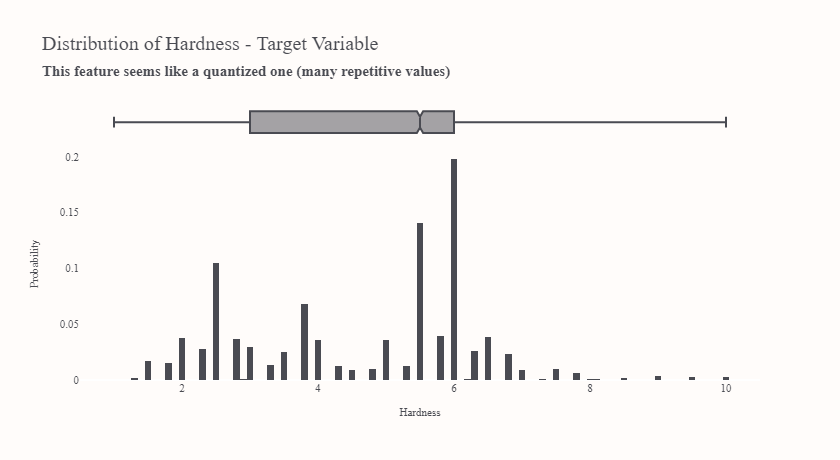

In [183]:
fig = px.histogram(
    train,
    x="Hardness",
    histnorm="probability",
    marginal="box",
    height=460,
    title="Distribution of Hardness - Target Variable<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "This feature seems like a quantized one (many repetitive values)</span>",
)
fig.update_yaxes(title="Probability", row=1)
save_and_show_fig(fig, "hardness_distribution")

In [92]:
print(CLR + "Training Dataset:")
train_summary = frame_summary(train)
get_pretty_frame(train_summary, gradient=True)

Training Dataset:


,Dtype,MissingValues,MissingValuesRatio,UniqueValues,UniqueValuesRatio,MostFreqValue,MostFreqValueCount,MostFreqValueCountRatio
allelectrons_Total,float64,0,0.000,325,0.031,100.000,822,0.079
density_Total,float64,0,0.000,1099,0.106,8.148,237,0.023
allelectrons_Average,float64,0,0.000,629,0.060,10.000,1602,0.154
val_e_Average,float64,0,0.000,205,0.020,4.800,2858,0.275
atomicweight_Average,float64,0,0.000,849,0.082,20.299,316,0.030
ionenergy_Average,float64,0,0.000,898,0.086,11.330,354,0.034
el_neg_chi_Average,float64,0,0.000,745,0.072,2.706,289,0.028
R_vdw_element_Average,float64,0,0.000,737,0.071,1.717,274,0.026
R_cov_element_Average,float64,0,0.000,698,0.067,0.910,344,0.033
zaratio_Average,float64,0,0.000,815,0.078,0.493,267,0.026


In [93]:
print(CLR + "Test Dataset:")
test_summary = frame_summary(test)
get_pretty_frame(test_summary, gradient=True)

Test Dataset:


,Dtype,MissingValues,MissingValuesRatio,UniqueValues,UniqueValuesRatio,MostFreqValue,MostFreqValueCount,MostFreqValueCountRatio
allelectrons_Total,float64,0,0.000,263,0.038,100.000,593,0.085
density_Total,float64,0,0.000,904,0.130,7.558,165,0.024
allelectrons_Average,float64,0,0.000,514,0.074,10.000,1094,0.158
val_e_Average,float64,0,0.000,185,0.027,4.800,1939,0.279
atomicweight_Average,float64,0,0.000,728,0.105,20.299,223,0.032
ionenergy_Average,float64,0,0.000,699,0.101,11.330,254,0.037
el_neg_chi_Average,float64,0,0.000,643,0.093,2.706,230,0.033
R_vdw_element_Average,float64,0,0.000,622,0.090,1.742,186,0.027
R_cov_element_Average,float64,0,0.000,592,0.085,0.910,240,0.035
zaratio_Average,float64,0,0.000,660,0.095,0.493,171,0.025


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Missing &amp; Unique &amp; Most Frequent Values</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    What's surprising there is no missing values, so we don't need to bother about imputation. We can see the ratio of unique values in both datasets is quite low for all features, which means that features consist of many repeatable values. This makes them more semi-continuous rather than continuous. The target variable has only $50$ unique values among more than $10000$ training samples, and in my opinion, it's more like a categorical feature.
</p>

In [94]:
print(CLR + "Training Dataset:")
train_num_descr = numeric_descr(train)
get_pretty_frame(train_num_descr, gradient=True)

Training Dataset:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
allelectrons_Total,128.054,224.124,0.000,6.000,36.000,68.000,100.000,131.000,278.000,719.400,15300.000
density_Total,14.491,15.973,0.000,0.740,2.333,7.558,10.650,16.677,37.007,75.099,643.094
allelectrons_Average,17.033,10.469,0.000,4.667,7.500,10.000,12.600,22.000,42.000,50.000,67.000
val_e_Average,4.547,0.691,0.000,2.000,3.500,4.000,4.714,4.800,5.600,5.667,6.000
atomicweight_Average,37.508,26.012,0.000,8.773,14.997,20.299,26.204,48.719,98.341,119.629,167.400
ionenergy_Average,10.938,1.408,0.000,8.054,9.014,10.591,11.203,11.671,12.373,13.513,15.246
el_neg_chi_Average,2.608,0.335,0.000,1.790,2.045,2.530,2.706,2.805,2.902,2.980,3.443
R_vdw_element_Average,1.731,0.192,0.000,1.319,1.518,1.673,1.733,1.800,1.943,2.055,2.250
R_cov_element_Average,0.944,0.180,0.000,0.505,0.708,0.864,0.916,0.982,1.233,1.390,1.616
zaratio_Average,0.493,0.063,0.000,0.405,0.448,0.476,0.489,0.496,0.616,0.707,0.826


In [95]:
print(CLR + "Test Dataset:")
test_num_descr = numeric_descr(test)
get_pretty_frame(test_num_descr, gradient=True)

Test Dataset:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
allelectrons_Total,126.460,207.564,0.000,14.000,33.000,68.000,100.000,128.000,278.000,710.000,10116.000
density_Total,14.794,18.982,0.000,0.772,2.333,7.558,10.650,16.601,37.777,105.514,643.094
allelectrons_Average,17.406,10.996,0.000,4.667,7.500,10.000,12.667,22.000,42.800,50.000,67.000
val_e_Average,4.547,0.683,0.000,2.025,3.500,4.000,4.750,4.800,5.600,5.800,6.000
atomicweight_Average,38.423,27.344,0.000,8.773,14.997,20.299,26.204,48.719,103.499,119.629,167.400
ionenergy_Average,10.922,1.379,0.000,8.054,8.917,10.584,11.203,11.646,12.302,13.513,15.246
el_neg_chi_Average,2.608,0.323,0.000,1.903,2.045,2.527,2.706,2.807,2.902,2.980,3.443
R_vdw_element_Average,1.738,0.191,0.000,1.319,1.542,1.678,1.736,1.820,1.980,2.087,2.250
R_cov_element_Average,0.950,0.179,0.000,0.520,0.710,0.867,0.920,0.990,1.253,1.390,1.615
zaratio_Average,0.492,0.061,0.000,0.403,0.446,0.476,0.489,0.496,0.614,0.696,0.826


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Numerical Summary</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here we have two features with some outliers. These are <code>allelectrons_Total</code> and <code>density_Total</code>. Nevertheless, both datasets overlap (see respective percentiles in both cases) for all attributes. It is most probable that they come from the same distribution.<br><br>
    Let's test the last consideration with <b>adversarial validation</b>. What is the adversarial validation? <b>Well, it's a very straightforward way to check whether our subsets are similar (sampled from the same or very similar distributions).</b> We label training and test datasets with, for example, $0$ and $1$. Then, we combine them into one dataset and shuffle them. Subsequently, we can perform binary classification and assess if we're able to identify which observation is from which dataset. When we get a ROC value of around $0.5$ (random guessing), they are indistinguishable, and this case is desired. On the other hand, when ROC $>0.5$, it probably means that training and test subsets are from different distributions.
</p>

In [96]:
train_av = train.drop("Hardness", axis=1).assign(AV=0)
test_av = test.assign(AV=1)

data_av = pd.concat((train_av, test_av), ignore_index=True)
data_av = data_av.sample(frac=1.0, random_state=42)

X = data_av.drop("AV", axis=1)
y = data_av.AV

y_proba = cross_val_predict(
    estimator=make_pipeline(StandardScaler(), LogisticRegression(random_state=42)),
    X=X,
    y=y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=19937),
    method="predict_proba",
)

av_scores = {
    "ConfusionMatrix": confusion_matrix(y, y_proba.argmax(axis=1)),
    "FPR-TPR-Threshold": roc_curve(y, y_proba[:, 1]),
    "ROC-AUC": roc_auc_score(y, y_proba[:, 1]),
}

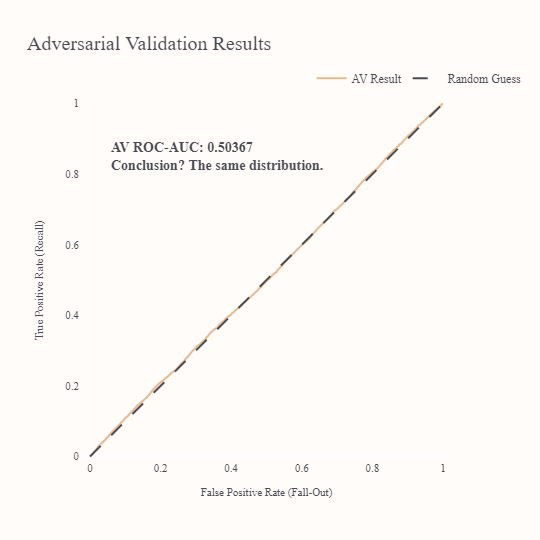

In [97]:
fig = go.Figure()
fig.add_scatter(
    x=av_scores["FPR-TPR-Threshold"][0],
    y=av_scores["FPR-TPR-Threshold"][1],
    name="AV Result",
    mode="lines",
    line_color=COLOR_SCHEME[2],
)
fig.add_scatter(
    x=[0, 1],
    y=[0, 1],
    name="Random Guess",
    mode="lines",
    line=dict(dash="longdash", color=COLOR_SCHEME[0]),
)
fig.add_annotation(
    x=0.05,
    y=0.85,
    align="left",
    xanchor="left",
    text=f"<b>AV ROC-AUC: {av_scores['ROC-AUC']:.5f}<br>"
    "Conclusion? The same distribution.",
    showarrow=False,
    font_size=14,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="True Positive Rate (Recall)",
)
fig.update_xaxes(
    scaleanchor="y",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="False Positive Rate (Fall-Out)",
)
fig.update_layout(
    title="Adversarial Validation Results",
    height=540,
    width=540,
    legend=dict(y=1.02, x=1.2),
)
save_and_show_fig(fig, "adversarial_validation")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Adversarial Validation Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, the result is excellent for us since ROC $\approx 0.5$ means that subsets are indistinguishable (they come from the same distribution). Let's see histograms yet.
</p>

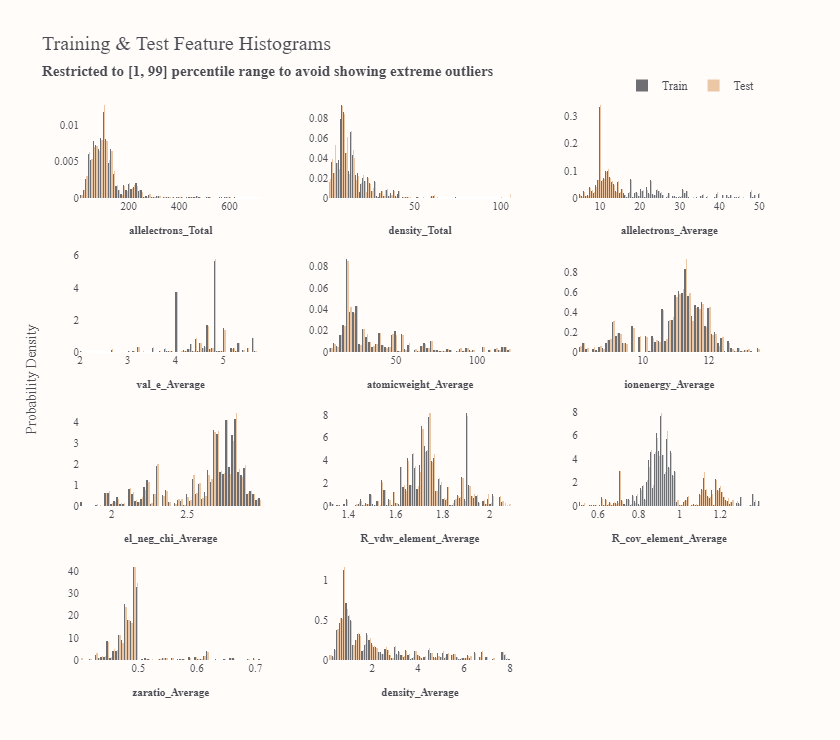

In [103]:
features = test.columns.to_list()

n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Probability Density",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
).update_annotations(font_size=14)

for frame, color, group in zip(
    (train, test), (COLOR_SCHEME[0], COLOR_SCHEME[2]), ("Train", "Test")
):
    for k, (var, (row, col)) in enumerate(zip(features, axes), start=1):
        start, end = np.percentile(frame[var], (1, 99))
        fig.add_histogram(
            x=frame[var],
            xbins=go.histogram.XBins(start=start, end=end),
            histnorm="probability density",
            marker_color=color,
            marker_line_width=0,
            opacity=0.8,
            name=group,
            legendgroup=group,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"<b>{var}</b>", row=row, col=col)

fig.update_layout(
    width=840,
    height=740,
    legend=dict(y=1, x=1),
    title="Training & Test Feature Histograms<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Restricted to [1, 99] percentile range to avoid showing extreme outliers</span>",
    bargap=0,
    bargroupgap=0,
)
save_and_show_fig(fig, "histograms")

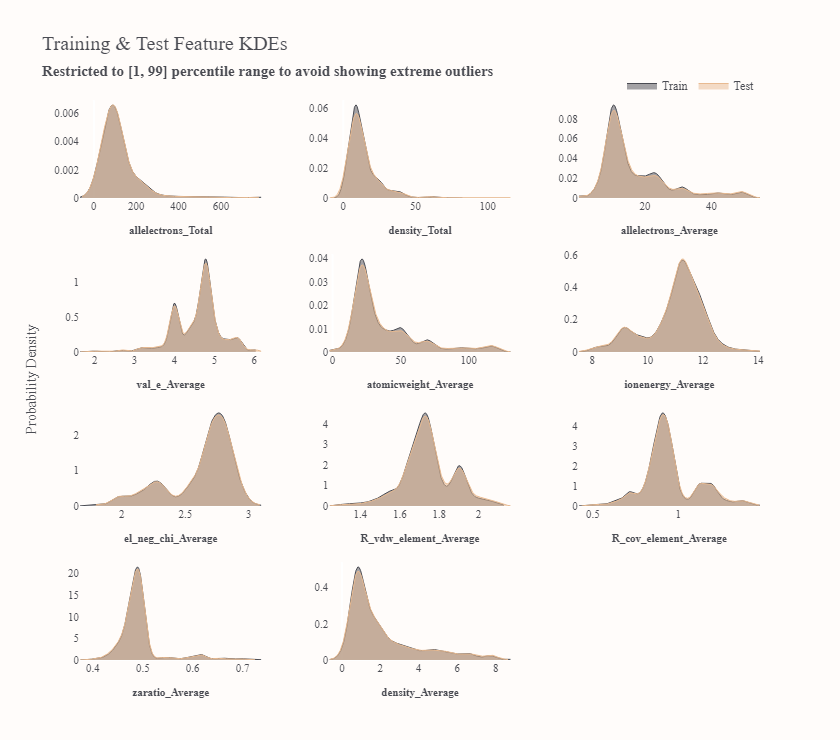

In [326]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Probability Density",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
).update_annotations(font_size=14)

for frame, color, group in zip(
    (train, test), (COLOR_SCHEME[0], COLOR_SCHEME[2]), ("Train", "Test")
):
    for k, (var, (row, col)) in enumerate(zip(features, axes), start=1):
        kde = get_kde_estimation(frame[var], percentile_range=(1, 99))
        fig.add_scatter(
            x=kde["space"],
            y=kde["vals"],
            line=dict(dash="solid", color=color, width=1),
            fill="tozeroy",
            name=group,
            legendgroup=group,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"<b>{var}</b>", row=row, col=col)

fig.update_layout(
    width=840,
    height=740,
    legend=dict(y=1, x=1),
    title="Training & Test Feature KDEs<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Restricted to [1, 99] percentile range to avoid showing extreme outliers</span>",
)
save_and_show_fig(fig, "kdes")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Feature Distributions</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Feature distributions confirm the previous statement, i.e. training and test subsets probably follow the same distribution, which is reflected as bins overlapping and similar density estimation. Let's continue analysis with correlation matrix and hierarchical clustering. 
</p>

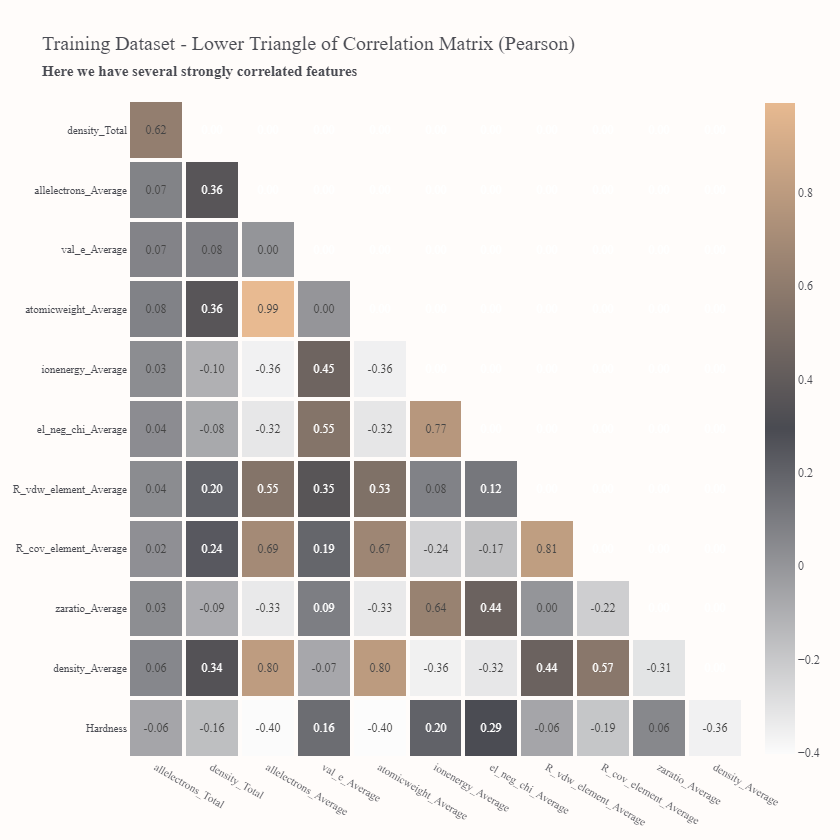

In [180]:
pearson_corr = train.corr(method="pearson")
lower_triu_corr = get_lower_triangular_frame(pearson_corr)

heatmap = go.Heatmap(
    z=lower_triu_corr,
    x=lower_triu_corr.columns,
    y=lower_triu_corr.index,
    text=lower_triu_corr.fillna(""),
    texttemplate="%{text:.2f}",
    xgap=4,
    ygap=4,
    showscale=True,
    colorscale=tuple(zip((0, 0.5, 1), COLOR_SCHEME[[1, 0, 2]])),
    colorbar_len=1.02,
    hoverinfo="none",
)
fig = go.Figure(heatmap)
fig.update_layout(
    title="Training Dataset - Lower Triangle of Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Here we have several strongly correlated features</span>",
    yaxis_autorange="reversed",
    width=840,
    height=840,
)
save_and_show_fig(fig, "pearson_corr_matrix")

In [123]:
abs_corr = (
    lower_triu_corr.abs()
    .unstack()
    .sort_values(ascending=False)  # type: ignore
    .rename("Absolute Pearson Correlation")
    .to_frame()
    .reset_index(names=["Feature 1", "Feature 2"])
    .dropna()
    .round(5)
)

with pd.option_context("display.max_rows", 10):
    print(abs_corr)

                Feature 1              Feature 2  Absolute Pearson Correlation
0    allelectrons_Average   atomicweight_Average                       0.99066
1   R_vdw_element_Average  R_cov_element_Average                       0.81182
2    allelectrons_Average        density_Average                       0.80364
3    atomicweight_Average        density_Average                       0.79656
4       ionenergy_Average     el_neg_chi_Average                       0.77405
..                    ...                    ...                           ...
61     allelectrons_Total        zaratio_Average                       0.03104
62     allelectrons_Total  R_cov_element_Average                       0.02442
63   allelectrons_Average          val_e_Average                       0.00438
64  R_vdw_element_Average        zaratio_Average                       0.00298
65          val_e_Average   atomicweight_Average                       0.00186

[66 rows x 3 columns]


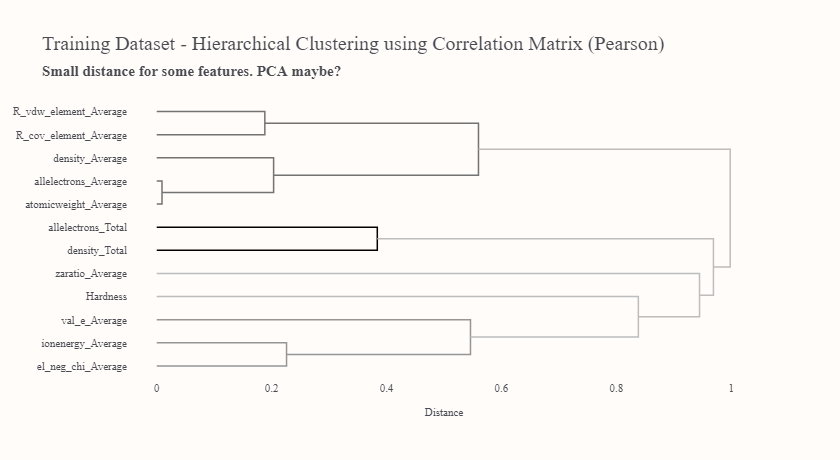

In [182]:
dissimilarity = 1 - np.abs(pearson_corr)

fig = ff.create_dendrogram(
    dissimilarity,
    labels=pearson_corr.columns,
    orientation="left",
    colorscale=px.colors.sequential.Greys[3:],
    # squareform() returns lower triangular in compressed form - as 1D array.
    linkagefun=lambda x: linkage(squareform(dissimilarity), method="complete"),
)
fig.update_xaxes(showline=False, title="Distance", ticks="", range=[-0.05, 1.05])
fig.update_yaxes(showline=False, ticks="")
fig.update_layout(
    title="Training Dataset - Hierarchical Clustering using Correlation Matrix (Pearson)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Small distance for some features. PCA maybe?</span>",
    height=460,
    width=840,
)
fig.update_traces(line_width=1.5, opacity=1)
save_and_show_fig(fig, "hierarchical_clustering")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Correlation Matrix &amp; Hierarchical Clustering</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Pearson matrix correlation shows several highly correlated pairs (five to be exact when considering threshold > $0.70$). I also checked Spearman correlations (which are based on ranks), and there are ten correlated pairs with a threshold > $0.70$. So, this dataset is more often characterized by non-linear dependencies rather than linear. Target variable correlates the most with <code>allelectrons_Average</code> and <code>atomicweight_Average</code>.<br><br>
    In hierarchical clustering, we had to provide dissimilarity (distance) between features. Basically, we can treat dissimilarity as $\textrm{dissimilarity} = 1 - |\textrm{correlation}|$, and that's all. This type of visualization may come in handy to assess whether a specific dimensionality reduction algorithm like PCA may be helpful. In this case, indeed, there is an obvious pair to be reduced: <code>allelectrons_Average</code> and <code>atomicweight_Average</code>. Perhaps features at the top of the plot also can be reduced. Let's have a look at scatter plots.
</p>

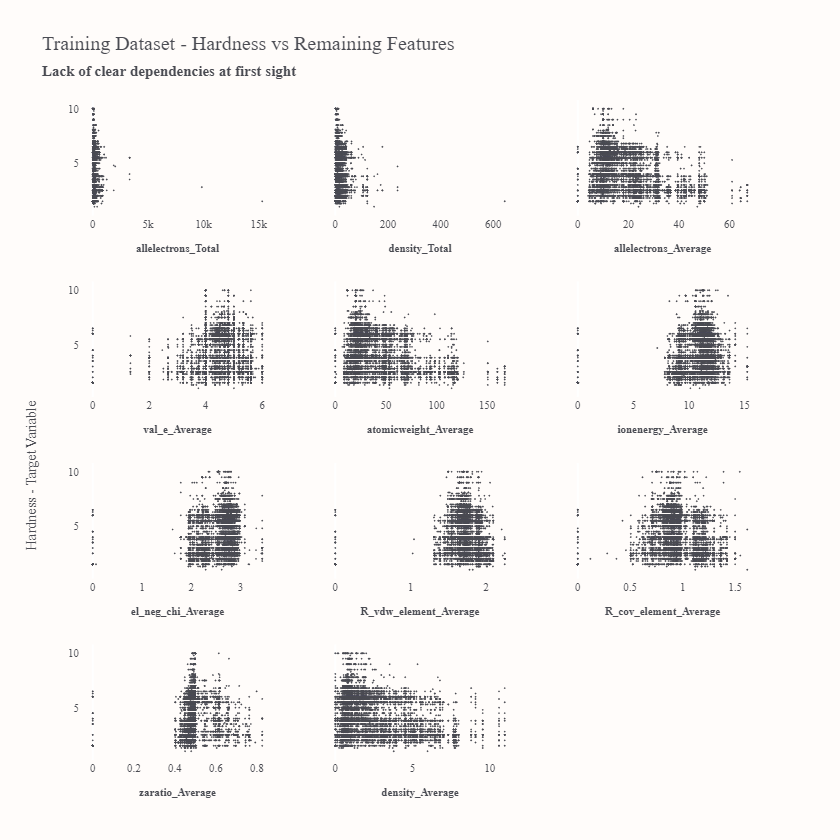

In [179]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Hardness - Target Variable",
    horizontal_spacing=0.07,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=14, yshift=-45)

for (row, col), feature in zip(axes, features):
    fig.add_scatter(
        x=train[feature],
        y=train.Hardness,
        mode="markers",
        name=feature,
        row=row,
        col=col,
    )
    fig.update_xaxes(
        title_text=f"<b>{feature}</b>",
        row=row,
        col=col,
    )
    if not col == 1:
        fig.update_yaxes(showticklabels=False, row=row, col=col)

fig.update_layout(
    title="Training Dataset - Hardness vs Remaining Features<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Lack of clear dependencies at first sight</span>",
    width=840,
    height=840,
    showlegend=False,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=1.5, color=COLOR_SCHEME[0])),
)
save_and_show_fig(fig, "scatter_plots")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Scatter Plots</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, at first sight, there are no clear dependencies between target variables and the other features. We can say it only for <code>allelectrons_Average</code>, <code>atomicweight_Average</code> and <code>density_Average</code>. In these cases, actually, the negative correlation is visible, but it's not so strong. As for the whole, we can see structurally deployed samples and straight patterns. That's the result of the low diversity of continuous variables and many repetitive values. Probably we can clip outliers in <code>allelectrons_Total</code> and <code>density_Total</code>.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.3</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Probability Plots &amp; Example Transformations</span></b><a class="anchor" id="probability_plots_and_example_transformations"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    This subsection focuses on the exploration of probability plots, which are a graphical technique used to determine if a variable adheres to a particular distribution, specifically the normal distribution in this case. <b>Probability plots display samples that follow a normal distribution along a straight diagonal line.</b> Some machine learning models make the assumption that variables follow a normal distribution. Consequently, the mentioned technique assists in determining the necessary transformations to improve the variable's alignment with that distribution. We will begin with examining the original values and observing the outcomes.
</p>

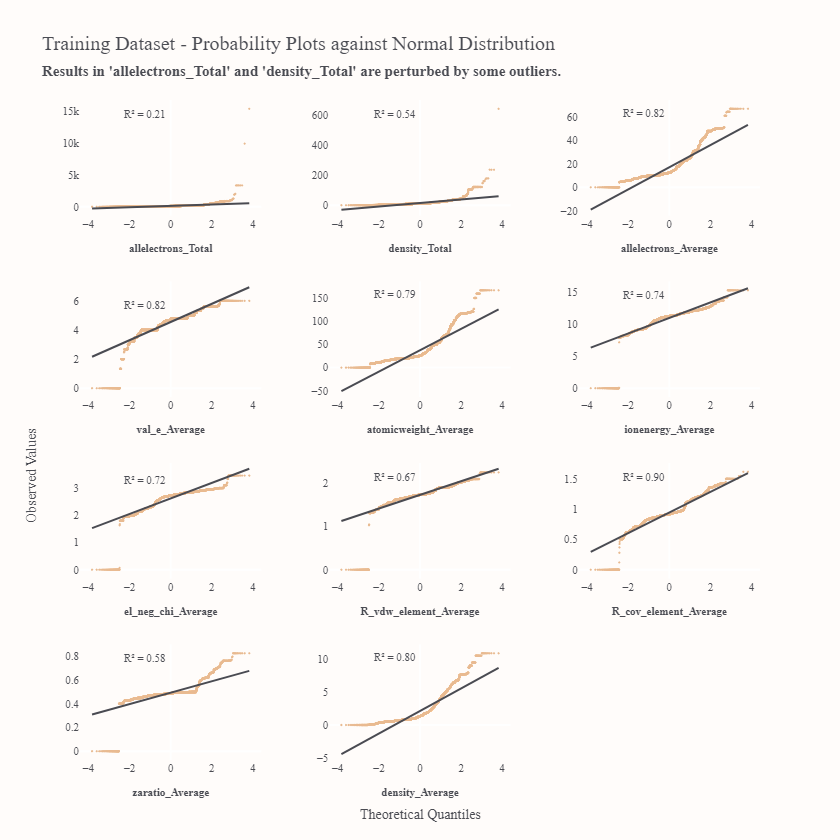

In [69]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Observed Values",
    x_title="Theoretical Quantiles",
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)
fig.update_annotations(font_size=14, yshift=-45)

for (row, col), feature in zip(axes, features):
    (osm, osr), (slope, intercept, R) = stats.probplot(
        train[feature].dropna(), rvalue=True
    )
    x_theory = np.array([osm[0], osm[-1]])
    y_theory = intercept + slope * x_theory
    R2 = f"R\u00b2 = {R * R:.2f}"
    fig.add_scatter(x=osm, y=osr, mode="markers", row=row, col=col, name=feature)
    fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=row, col=col)
    fig.add_annotation(
        x=-1.25,
        y=osr[-1] * 0.95,
        text=R2,
        showarrow=False,
        row=row,
        col=col,
        font_size=11,
    )
    fig.update_xaxes(
        title_text=f"<b>{feature}</b>",
        row=row,
        col=col,
    )

fig.update_layout(
    title="Training Dataset - Probability Plots against Normal Distribution<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Results in 'allelectrons_Total' and 'density_Total' are perturbed by some outliers</span>",
    width=840,
    height=840,
    showlegend=False,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color=COLOR_SCHEME[2])),
    line_color=COLOR_SCHEME[0],
)
save_and_show_fig(fig, "probability_plots")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Probability Plots against Normal Distribution</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    As you can see, some variables fit a normal distribution well, which manifests by a high coefficient of determination (R-squared) and evenly deployed samples around the straight line. However, there are same of features which have a poor fit. We can improve that through specific transformations. Mostly used transformations are log-level and square-root ones. These work fine with right-skewed data and help to reduce the impact of outliers. Another transformation is, for example, a reciprocal one, which is sometimes used when data is skewed, or there are obvious outliers. More sophisticated methods are Box-Cox transformation (requires strictly positive numbers) and Yeo-Johnson (variation of Box-Cox), which has no restrictions concerning numbers. We will check three of mentioned: log-level, square-root and Yeo-Johnson. For this case, we will utilise the <code>probplot</code> function from the <code>scipy</code> module to get R-squared coefficients as earlier.
</p>

In [42]:
r2_scores = pd.DataFrame(index=("Original", "YeoJohnson", "Log", "Sqrt"))

for feature in features:
    orig = train[feature].dropna()
    _, (*_, R_orig) = stats.probplot(orig, rvalue=True)
    _, (*_, R_yeojohn) = stats.probplot(stats.yeojohnson(orig)[0], rvalue=True)
    _, (*_, R_log) = stats.probplot(np.log1p(orig), rvalue=True)
    _, (*_, R_sqrt) = stats.probplot(np.sqrt(orig), rvalue=True)

    r2_scores[feature] = (
        R_orig * R_orig,
        R_yeojohn * R_yeojohn,
        R_log * R_log,
        R_sqrt * R_sqrt,
    )

r2_scores = r2_scores.transpose()
r2_scores["Winner"] = r2_scores.idxmax(axis=1)
get_pretty_frame(r2_scores)

,Original,YeoJohnson,Log,Sqrt,Winner
allelectrons_Total,0.215,0.919,0.876,0.770,YeoJohnson
density_Total,0.536,0.979,0.979,0.885,YeoJohnson
allelectrons_Average,0.817,0.921,0.908,0.903,YeoJohnson
val_e_Average,0.816,0.951,0.543,0.562,YeoJohnson
atomicweight_Average,0.795,0.917,0.891,0.896,YeoJohnson
ionenergy_Average,0.737,0.947,0.340,0.448,YeoJohnson
el_neg_chi_Average,0.718,0.926,0.503,0.455,YeoJohnson
R_vdw_element_Average,0.672,0.942,0.465,0.375,YeoJohnson
R_cov_element_Average,0.895,0.914,0.826,0.689,YeoJohnson
zaratio_Average,0.583,0.612,0.535,0.376,YeoJohnson


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>R-squared Scores within Some Transformations</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Well, as you can see <b>Yeo-Johnson's transformation wins in all cases and improves fit to the normal distribution pretty well</b> ($R^2$ scores almost in all cases are above $0.90$). However, there is a one feature where none of the transformations helps, i.e. <code>zaratio_Average</code>. Probably it's the effect of specific shape of this feature (looks like a half-normal distribution). Let's see how Yeo-Johnson transformation helps with specific feature, for example, the <code>density_Total</code> one.
</p>

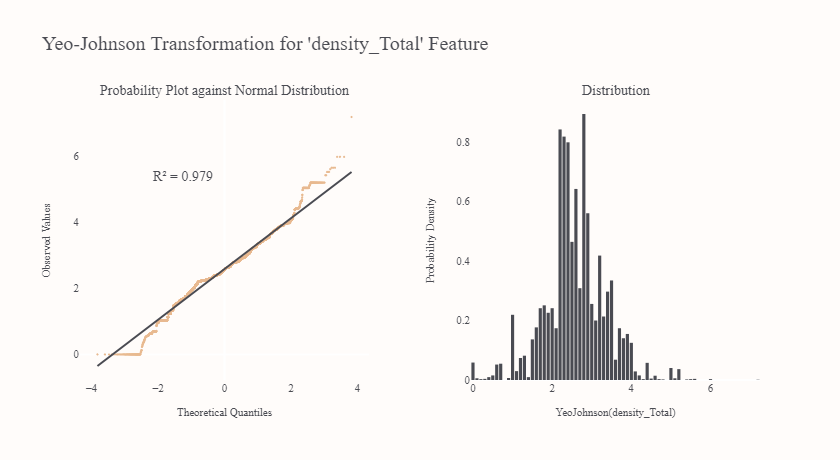

In [181]:
density_Total_transformed = stats.yeojohnson(train.density_Total.dropna())[0]
(osm, osr), (slope, intercept, R) = stats.probplot(
    density_Total_transformed, rvalue=True
)
x_theory = np.array([osm[0], osm[-1]])
y_theory = intercept + slope * x_theory

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Probability Plot against Normal Distribution", "Distribution"],
    horizontal_spacing=0.15,
)

fig.add_scatter(
    x=osm, y=osr, mode="markers", row=1, col=1, name="YeoJohnson(density_Total)"
)
fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=1, col=1)
fig.add_annotation(
    x=-1.25,
    y=osr[-1] * 0.75,
    text=f"R\u00b2 = {R * R:.3f}",
    showarrow=False,
    row=1,
    col=1,
)
fig.update_yaxes(title_text="Observed Values", row=1, col=1)
fig.update_xaxes(title_text="Theoretical Quantiles", row=1, col=1)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color=COLOR_SCHEME[2])),
    line_color=COLOR_SCHEME[0],
)

fig.add_histogram(
    x=density_Total_transformed,
    xbins=go.histogram.XBins(size=0.1),
    marker_color=COLOR_SCHEME[0],
    name="YeoJohnson(density_Total)",
    histnorm="probability density",
    row=1,
    col=2,
)
fig.update_yaxes(title_text="Probability Density", row=1, col=2)
fig.update_xaxes(title_text="YeoJohnson(density_Total)", row=1, col=2)

fig.update_layout(
    title="Yeo-Johnson Transformation for 'density_Total' Feature",
    showlegend=False,
    width=840,
    height=460,
    bargap=0.2,
)

fig.update_annotations(font_size=14)
save_and_show_fig(fig, "density_Total_after_transform")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #E8BA91;
">
    <b>Yeo-Johnson Transformation</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    It looks pretty well. We can include this type of transform in the preprocessing pipeline. Models like SVM and Linear Regression should be grateful.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #E8BA91'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Features Importance</span></b><a class="anchor" id="features_importance"></a> [↑](#top)

In [ ]:
# TODO: